In [1]:
import os
import pandas as pd

import pickle

from datetime import timedelta
import numpy as np
from tqdm.notebook import tqdm

In [2]:
def poly(x, degree):
    return np.vander(x, degree + 1, increasing=True)[:, 1:]

In [3]:
df_seas = pd.read_csv('../data/ground/cattle_weights/cper_carm_trm_weights_with_individual_gains_2024-10-17.csv',
                      parse_dates=['Season.on.date', 'Season.off.date'])
df_fq = pd.read_csv('../data/training/cper_pasture_2000_2024_fq_predictions.csv', 
                    parse_dates=['date'])
df_bm = pd.read_csv('../summarize_pastures/outputs/cper_pasture_biomass_2000_2024.csv',
                    parse_dates=['date'])
df_fq_obs = pd.read_csv('../data/training/fecal_quality_2014_2023_pheno_metrics.csv',
                        parse_dates=['Date'])
df_bm_obs = pd.read_csv('../data/training/vor_2014_2023_cln_2024_04_04_plot_hls_idxs.csv',
                        parse_dates=['Date', 'Date_mean'])

In [4]:
df_seas['outlier_upr'] = df_seas.groupby(['Herd', 'Season.on.date'])['ADG_shrunk'].transform(lambda x: x.mean()+x.std()*3)
df_seas['outlier_lwr'] = df_seas.groupby(['Herd', 'Season.on.date'])['ADG_shrunk'].transform(lambda x: x.mean()-x.std()*3)
df_seas['outlier'] = df_seas.apply(
    lambda x: 1 if (x['ADG_shrunk'] > x['outlier_upr']) or (x['ADG_shrunk'] < x['outlier_lwr']) else 0, axis=1)

In [5]:
df_seas[df_seas['outlier']==1]

,Year,Treatment,Herd,Allocation.number,Tag,Season.on.date,Season.off.date,Weight_Shrunk.on,Weight_Shrunk.off,Season.Days,Gain_shrunk,ADG_shrunk,outlier_upr,outlier_lwr,outlier
474,2014,CARM,CARM,214,810,2014-05-15,2014-10-02,608.22,691.92,140.0,83.70,0.597857,2.753293,0.725578,1
485,2014,CARM,CARM,214,857,2014-05-15,2014-10-02,703.08,794.22,140.0,91.14,0.651000,2.753293,0.725578,1
886,2015,CARM,CARM,224,752,2015-05-15,2015-10-02,617.52,744.00,140.0,126.48,0.903429,2.674304,0.996172,1
935,2015,CARM,CARM,224,1039,2015-05-15,2015-10-02,571.02,686.34,140.0,115.32,0.823714,2.674304,0.996172,1
1229,2016,CARM,CARM,234,261,2016-05-13,2016-09-30,531.96,946.74,140.0,414.78,2.962714,2.745653,1.102718,1
1242,2016,CARM,CARM,234,329,2016-05-13,2016-09-30,507.78,662.16,140.0,154.38,1.102714,2.745653,1.102718,1
1368,2016,CARM,CARM,234,846,2016-05-13,2016-09-30,667.74,809.10,140.0,141.36,1.009714,2.745653,1.102718,1
1591,2016,TRM,5E,24,191,2016-05-13,2016-09-30,723.54,1218.30,140.0,494.76,3.534000,3.524822,1.588445,1
1859,2017,CARM,CARM,243,921,2017-05-11,2017-09-29,658.44,792.36,141.0,133.92,0.949787,2.886604,1.238008,1
2262,2018,CARM,CARM,280,638,2018-05-10,2018-09-28,543.12,898.38,141.0,355.26,2.519574,2.441657,0.599535,1


In [39]:
#with open('../models/weight_gain/rf_28day_wts_2000_2024.pkl', 'rb') as f:
#    rf_adg = pickle.load(f)
with open('../models/weight_gain/rf_28day_wts_2000_2024_5.pkl', 'rb') as f:
    rf_adg = pickle.load(f)
with open('../models/weight_gain/lm_28day_wts_2000_2024_sqrt.pkl', 'rb') as f:
    lm_adg = pickle.load(f)

In [40]:
rf_adg

Pipeline(steps=[('scaler', StandardScaler()),
                ('RF',
                 RandomForestRegressor(max_features=1, max_samples=0.25,
                                       n_jobs=4))])

In [41]:
lm_adg

In [42]:
df_seas_cln = df_seas[(df_seas['Treatment'] != 'CARM') & (df_seas['outlier']==0)].drop(
    columns=['Tag', 'Treatment']).groupby(
    ['Year', 'Herd', 'Season.on.date', 'Season.off.date']
).mean().reset_index()

In [43]:
df_seas_cln[df_seas_cln['Year'] == 2022]

,Year,Herd,Season.on.date,Season.off.date,Allocation.number,Weight_Shrunk.on,Weight_Shrunk.off,Season.Days,Gain_shrunk,ADG_shrunk,outlier_upr,outlier_lwr,outlier


In [44]:
df_seas_cln = df_seas_cln.rename(columns={'Allocation.number': 'on_ct', 'Weight_Shrunk.on': 'on_wt'})

In [45]:
#df_seas_cln['on_au'] = df_seas_cln['on_wt']/1000*df_seas_cln['on_ct']

In [46]:
def pred_adg(mod, idx, row, adg_dict, full_dict):
    df_fq_tmp = df_fq[(df_fq['date'].between(row['Season.on.date'],# - timedelta(days=28),
                                             row['Season.off.date'], 
                                             inclusive='both')) &
    (df_fq['Pasture'] == row['Herd'])][['date', 'CP_pred', 'DOM_pred']]
    df_bm_tmp = df_bm[(df_bm['date'].between(row['Season.on.date'],# - timedelta(days=28),
                                             row['Season.off.date'], 
                                             inclusive='both')) &
        (df_bm['Pasture'] == row['Herd'])][['date', 'Biomass_kg_ha']]
    
    df_pred_tmp = pd.merge(df_fq_tmp, df_bm_tmp, on='date')
    
    df_pred_tmp = df_pred_tmp.rename(columns={'CP_pred': 'CP', 'DOM_pred': 'DOM'})
    
    df_pred_tmp = df_pred_tmp.set_index('date').rolling(window=timedelta(days=28), min_periods=1, center=False).mean().reset_index()
    
    df_pred_tmp = df_pred_tmp[(df_pred_tmp['date'] >= row['Season.on.date'])&
    (df_pred_tmp['date'] <= row['Season.off.date'])].copy().reset_index(drop=True)
    
    df_pred_tmp['adg'] = np.nan
    
    for i in range(len(df_pred_tmp)):
        pred_row_tmp = df_pred_tmp.iloc[[i]].copy()
        pred_row_tmp['on_ct'] = row['on_ct']
        if i == 0:
            pred_row_tmp['on_wt'] = row['on_wt']
        else:
            pred_row_tmp['on_wt'] = row['on_wt'] + df_pred_tmp['adg'].iloc[:i].sum()
        pred_row_tmp['on_au'] = pred_row_tmp['on_wt']/1000*pred_row_tmp['on_ct']
        if type(mod) == type(rf_adg):
            adg_pred_tmp = mod.predict(pred_row_tmp.drop(columns=['date', 'adg'] + [c for c in pred_row_tmp if c not in rf_adg.feature_names_in_]))
        else:
            adg_pred_tmp = mod.predict(pred_row_tmp).values
        df_pred_tmp.loc[i, 'adg'] = adg_pred_tmp
        df_pred_tmp.loc[i, 'wt_pred'] = pred_row_tmp['on_wt'].values
        
    adg_out = df_pred_tmp['adg'].mean().round(2)
    adg_dict[idx] = adg_out
    full_dict[idx] = df_pred_tmp


In [47]:
df_seas_cln

,Year,Herd,Season.on.date,Season.off.date,on_ct,on_wt,Weight_Shrunk.off,Season.Days,Gain_shrunk,ADG_shrunk,outlier_upr,outlier_lwr,outlier
0,2013,15E,2013-05-30,2013-09-28,20.0,564.975000,858.204000,121.0,293.229000,2.423380,3.686690,1.160071,0.0
1,2013,17N,2013-05-30,2013-09-28,14.0,563.007692,854.741538,121.0,291.733846,2.411024,3.595136,1.226911,0.0
2,2013,19N,2013-05-30,2013-09-28,14.0,570.754286,892.534286,121.0,321.780000,2.659339,3.388492,1.930186,0.0
3,2013,20SE,2013-05-30,2013-09-28,14.0,572.481429,876.591429,121.0,304.110000,2.513306,3.706810,1.319802,0.0
4,2013,24W,2013-05-30,2013-09-28,14.0,562.517143,842.447143,121.0,279.930000,2.313471,3.502443,1.124499,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2023,25SE,2023-05-19,2023-09-29,17.0,573.700588,876.552353,133.0,302.851765,2.277081,3.278519,1.275643,0.0
106,2023,26E,2023-05-19,2023-09-29,17.0,584.805882,891.651176,133.0,306.845294,2.307107,3.483072,1.131143,0.0
107,2023,31E,2023-05-19,2023-09-29,21.0,589.032632,907.337368,133.0,318.304737,2.393269,3.386886,1.399651,0.0
108,2023,5E,2023-05-19,2023-09-29,19.0,596.472632,929.510526,133.0,333.037895,2.504044,3.788053,1.220036,0.0


In [48]:
import multiprocessing
from multiprocessing import Process

In [49]:
manager = multiprocessing.Manager()
adg_dict = manager.dict()
full_dict = manager.dict()

processes = [Process(target=pred_adg, args=(rf_adg, idx,row, adg_dict, full_dict)) for idx, row in df_seas_cln.iterrows()]

jobs = []
# start all processes
for process in processes:
    jobs.append(process)
    process.start()
# wait for all processes to complete
for process in tqdm(jobs):
    process.join()

  0%|          | 0/110 [00:00<?, ?it/s]

In [50]:
#return_dict.keys()

In [51]:
adg_pred = pd.Series(adg_dict.values(), index=adg_dict.keys()).sort_index()

In [52]:
df_seas_cln['adg_pred'] = adg_pred

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
df_seas_cln['Year'] = df_seas_cln['Year'].astype(str)

In [55]:
df_seas_cln = df_seas_cln[df_seas_cln['Year'] != '2013'].copy()

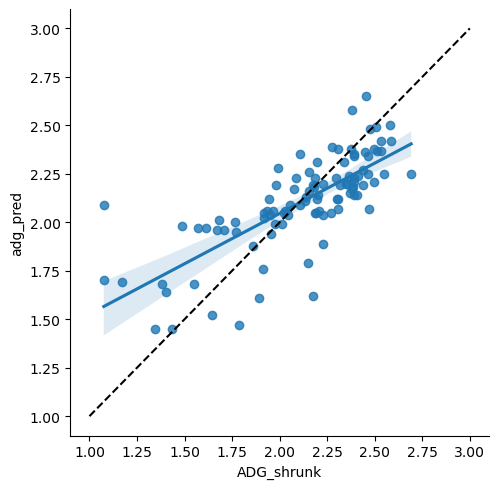

In [56]:
p_yr = sns.lmplot(x='ADG_shrunk', y='adg_pred', data=df_seas_cln)
for ax in p_yr.axes.flatten():
    ax.plot(np.arange(1.0, 4.0), np.arange(1.0, 4.0), color='black', linestyle='dashed')

In [57]:
df_seas_cln[['ADG_shrunk', 'adg_pred']].corr()

,ADG_shrunk,adg_pred
ADG_shrunk,1.000000,0.750533
adg_pred,0.750533,1.000000


In [58]:
mae = df_seas_cln.apply(lambda x: abs(x['adg_pred']-x['ADG_shrunk']), axis=1).mean().round(2)
print(mae)

0.17


In [59]:
mae/df_seas_cln['ADG_shrunk'].mean().round(2)*100

8.018867924528301

In [60]:
df_seas['Year'] = df_seas['Year'].astype(str)
df_seas = pd.merge(df_seas, df_seas_cln[['Year', 'Herd', 'Season.on.date', 'Season.off.date']],
                   how='left', on=['Year', 'Herd', 'Season.on.date', 'Season.off.date'])

In [61]:
#df_seas_cln

In [62]:
df_seas_cln['ADG_shrunk_lwr'] = df_seas[(df_seas['Treatment'] != 'CARM') &
(df_seas['outlier']==0) &
(df_seas['Year'] != '2013')].groupby(
    ['Year', 'Herd', 'Season.on.date', 'Season.off.date'])['ADG_shrunk'].quantile(0.05).values

df_seas_cln['ADG_shrunk_upr'] = df_seas[(df_seas['Treatment'] != 'CARM') &
(df_seas['outlier']==0) &
(df_seas['Year'] != '2013')].groupby(
    ['Year', 'Herd', 'Season.on.date', 'Season.off.date'])['ADG_shrunk'].quantile(0.95).values

In [63]:
df_seas_cln['ADG_shrunk_lwr_err'] = df_seas_cln['ADG_shrunk'] - df_seas_cln['ADG_shrunk_lwr']
df_seas_cln['ADG_shrunk_upr_err'] = df_seas_cln['ADG_shrunk_upr'] - df_seas_cln['ADG_shrunk']

In [64]:
#sns.pointplot(data=df_seas[(df_seas['Treatment'] != 'CARM') & (df_seas['outlier']==0)],
#                x='ADG_shrunk',
#                y='adg_pred', hue='Year', legend=False, ci='sd')

In [65]:
yr_colors = []
for _, row in df_seas_cln.iterrows():
    yr_colors.append(sns.color_palette('tab10')[list(df_seas_cln['Year'].unique()).index(row['Year'])])

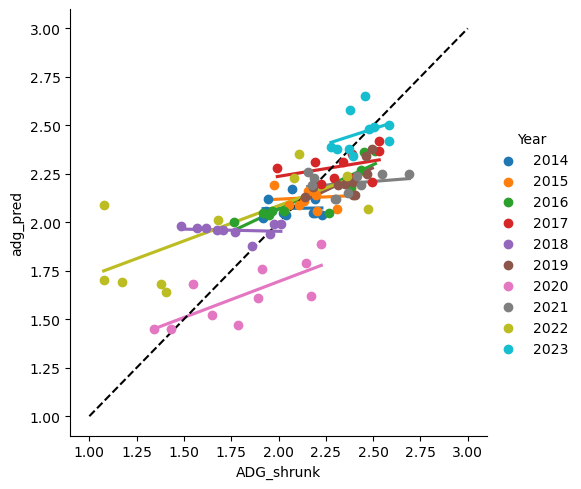

In [66]:
p_yr = sns.lmplot(x='ADG_shrunk', y='adg_pred', hue='Year', ci=None, #line_kws={'linewidth': 0},
                  data=df_seas_cln, scatter_kws={"zorder":10, "alpha":1})
for ax in p_yr.axes.flatten():
    ax.plot(np.arange(1.0, 4.0), np.arange(1.0, 4.0), color='black', linestyle='dashed')
    #ax.errorbar(df_seas_cln['ADG_shrunk'], df_seas_cln['adg_pred'], fmt='none',
    #            xerr=(df_seas_cln['ADG_shrunk_lwr_err'], df_seas_cln['ADG_shrunk_upr_err']),
    #            ecolor=yr_colors, zorder=1)

In [67]:
df_corr_yr = df_seas_cln.groupby(['Year'])[['ADG_shrunk', 'adg_pred']].corr()
df_corr_yr['adg_pred'][df_corr_yr['adg_pred'] != 1.0].mean().round(2)

0.4

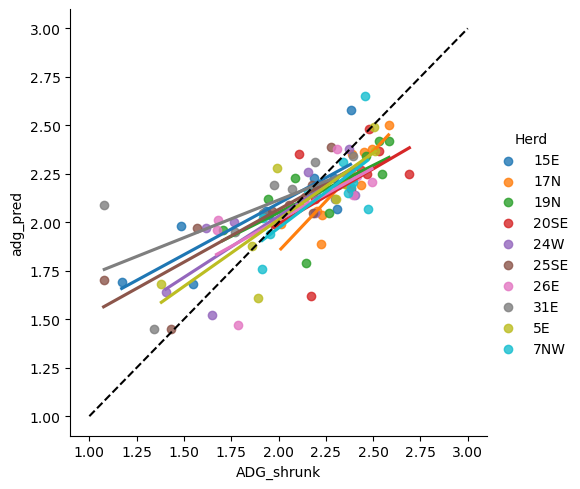

In [68]:
p_herd = sns.lmplot(x='ADG_shrunk', y='adg_pred', hue='Herd', ci=None, data=df_seas_cln)
for ax in p_herd.axes.flatten():
    ax.plot(np.arange(1.0, 4.0), np.arange(1.0, 4.0), color='black', linestyle='dashed')

In [69]:
df_corr_herd = df_seas_cln.groupby(['Herd'])[['ADG_shrunk', 'adg_pred']].corr()
df_corr_herd['adg_pred'][df_corr_herd['adg_pred'] != 1.0].mean().round(2)

0.75

In [503]:
past1 = '15E'
past2 = '15E'
yr1 = '2022'
yr2 = '2020'
df_pred_tmp1 = full_dict[df_seas_cln[(df_seas_cln['Herd'] == past1) & (df_seas_cln['Year'] == yr1)].index.values.item()]
df_pred_tmp2 = full_dict[df_seas_cln[(df_seas_cln['Herd'] == past2) & (df_seas_cln['Year'] == yr2)].index.values.item()]

In [504]:
df_fq_obs_tmp1 = df_fq_obs[(df_fq_obs['PastureID'] == past1) & (df_fq_obs['Year'].astype(str) == yr1)].copy()
df_fq_obs_tmp2 = df_fq_obs[(df_fq_obs['PastureID'] == past2) & (df_fq_obs['Year'].astype(str) == yr2)].copy()
df_bm_obs_tmp1 = df_bm_obs[(df_bm_obs['Pasture'] == past1) & (df_bm_obs['Year'].astype(str) == yr1)].copy()
df_bm_obs_tmp2 = df_bm_obs[(df_bm_obs['Pasture'] == past2) & (df_bm_obs['Year'].astype(str) == yr2)].copy()
df_seas_obs_tmp1 = df_seas[(df_seas['Herd'] == past1) & (df_seas['Year'].astype(str) == yr1)].copy()
df_seas_obs_tmp2 = df_seas[(df_seas['Herd'] == past2) & (df_seas['Year'].astype(str) == yr2)].copy()

In [505]:
df_bm_obs_tmp1['DOY'] = df_bm_obs_tmp1['Date_mean'].dt.dayofyear
df_bm_obs_tmp2['DOY'] = df_bm_obs_tmp2['Date_mean'].dt.dayofyear

In [506]:
df_fq_obs.columns

Index(['Concatenate', 'Year', 'Pasture Name', 'PastureID', 'Treatment', 'Herd',
       'Week', 'Date', 'Rotation', 'Crude Protein (%)', 'DOM(%)', 'DOM/CP',
       'Fecal Nitrogen (%)', 'Fecal Phosphorus (%)', 'Tag #'s', 'Notes',
       'Ecological Site', 'Julian Day', 'Precip(mm)', 'HerdTreat', 'WOY',
       'DOY', 'Phase', 'NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG', 'iNDVI_dry',
       'SOS_doy', 't_SOS'],
      dtype='object')

In [507]:
import matplotlib.dates as mdates

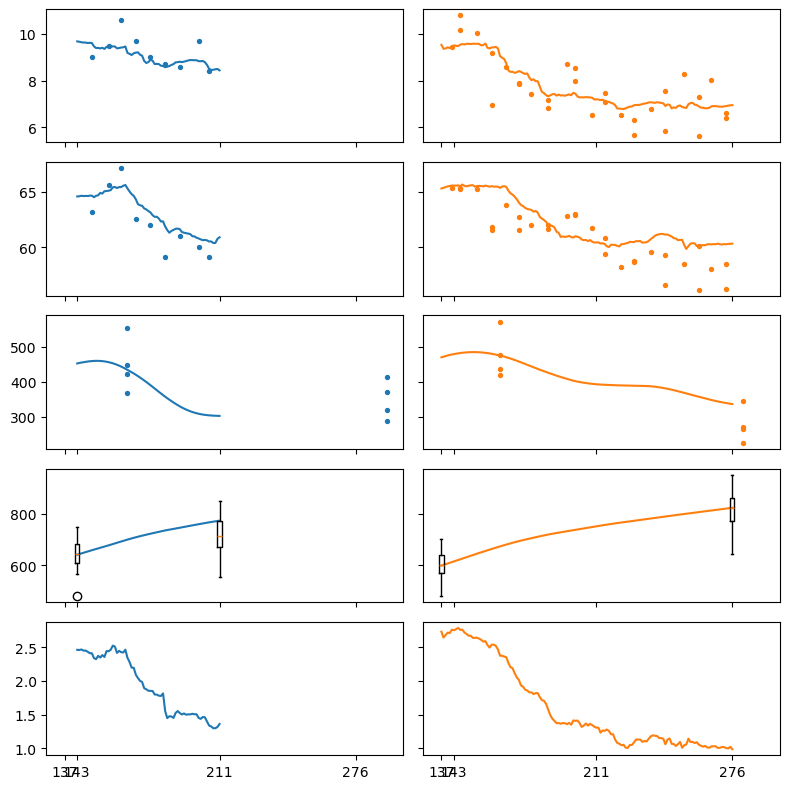

In [523]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(8,8), sharey='row', sharex=True)
#sns.pointplot(x='DOY', y='Biomass_kg_ha', data=df_bm_obs_tmp1, ax=axs[2,0])

axs[0, 0].plot(df_pred_tmp1['date'].dt.dayofyear, df_pred_tmp1['CP'], c='tab:blue')
axs[1, 0].plot(df_pred_tmp1['date'].dt.dayofyear, df_pred_tmp1['DOM'], c='tab:blue')
axs[2, 0].plot(df_pred_tmp1['date'].dt.dayofyear, df_pred_tmp1['Biomass_kg_ha'], c='tab:blue')
axs[4, 0].plot(df_pred_tmp1['date'].dt.dayofyear, df_pred_tmp1['adg'], c='tab:blue')
axs[3, 0].plot(df_pred_tmp1['date'].dt.dayofyear, df_pred_tmp1['wt_pred'], c='tab:blue')
#axs[3, 0].xaxis.set_major_locator(mdates.MonthLocator())

axs[0, 1].plot(df_pred_tmp2['date'].dt.dayofyear, df_pred_tmp2['CP'], c='tab:orange')
axs[1, 1].plot(df_pred_tmp2['date'].dt.dayofyear, df_pred_tmp2['DOM'], c='tab:orange')
axs[2, 1].plot(df_pred_tmp2['date'].dt.dayofyear, df_pred_tmp2['Biomass_kg_ha'], c='tab:orange')
axs[4, 1].plot(df_pred_tmp2['date'].dt.dayofyear, df_pred_tmp2['adg'], c='tab:orange')
axs[3, 1].plot(df_pred_tmp2['date'].dt.dayofyear, df_pred_tmp2['wt_pred'], c='tab:orange')

#axs[3, 0].xaxis.set_major_locator(mdates.MonthLocator())

axs[0, 0].scatter(df_fq_obs_tmp1['DOY'], df_fq_obs_tmp1['Crude Protein (%)'], c='tab:blue', s=8)
axs[0, 1].scatter(df_fq_obs_tmp2['DOY'], df_fq_obs_tmp2['Crude Protein (%)'], c='tab:orange', s=8)

axs[1, 0].scatter(df_fq_obs_tmp1['DOY'], df_fq_obs_tmp1['DOM(%)'], c='tab:blue', s=8)
axs[1, 1].scatter(df_fq_obs_tmp2['DOY'], df_fq_obs_tmp2['DOM(%)'], c='tab:orange', s=8)

axs[2, 0].scatter(df_bm_obs_tmp1['DOY'], df_bm_obs_tmp1['Biomass_kg_ha'], c='tab:blue', s=8)
axs[2, 1].scatter(df_bm_obs_tmp2['DOY'], df_bm_obs_tmp2['Biomass_kg_ha'], c='tab:orange', s=8)

axs[3, 0].boxplot([df_seas_obs_tmp1['Weight_Shrunk.on'],df_seas_obs_tmp1['Weight_Shrunk.off']], 
                  vert=True, 
                  widths=[2.0, 2.0],
                  positions=[df_seas_obs_tmp1['Season.on.date'].iloc[0].dayofyear,
                             df_seas_obs_tmp1['Season.off.date'].iloc[0].dayofyear])
axs[3, 1].boxplot([df_seas_obs_tmp2['Weight_Shrunk.on'],df_seas_obs_tmp2['Weight_Shrunk.off']], 
                  vert=True, 
                  widths=[2.0, 2.0],
                  positions=[df_seas_obs_tmp2['Season.on.date'].iloc[0].dayofyear,
                             df_seas_obs_tmp2['Season.off.date'].iloc[0].dayofyear])

#on_wt1 = df_pred_tmp1['wt_pred'].iloc[0]
#for idx, row in df_seas_obs_tmp1.iterrows():
#    axs[3, 0].plot([row['Season.on.date'].dayofyear, row['Season.off.date'].dayofyear],
#                    [on_wt1, on_wt1 + row['Gain_shrunk']], c='grey', alpha=0.25)

#on_wt2 = df_pred_tmp2['wt_pred'].iloc[0]
#for idx, row in df_seas_obs_tmp2.iterrows():
#    axs[3, 1].plot([row['Season.on.date'].dayofyear, row['Season.off.date'].dayofyear],
#                    [on_wt2, on_wt2 + row['Gain_shrunk']], c='grey', alpha=0.25)

#axs[4, 0].scatter(df_seas_obs_tmp1['Season.on.date'].dt.dayofyear,
#                  df_seas_obs_tmp1['Weight_Shrunk.on'], c='tab:blue', s=8)
#axs[4, 0].scatter(df_seas_obs_tmp1['Season.off.date'].dt.dayofyear,
#                 df_seas_obs_tmp1['Weight_Shrunk.off'], c='tab:blue', s=8)
#axs[4, 1].scatter(df_bm_obs_tmp2['DOY'], df_bm_obs_tmp2['Biomass_kg_ha'], c='tab:orange', s=8)

fig.tight_layout()

In [517]:
df_seas_obs_tmp1['Season.on.date'].iloc[0].dayofyear

143

In [191]:
df_seas_cln[(df_seas_cln['Year'] == yr2)]

,Year,Herd,Season.on.date,Season.off.date,on_ct,on_wt,Weight_Shrunk.off,Season.Days,Gain_shrunk,ADG_shrunk,outlier_upr,outlier_lwr,outlier,adg_pred
0,2013,15E,2013-05-30,2013-09-28,20.0,564.975000,858.204000,121.0,293.229000,2.423380,3.686690,1.160071,0.0,2.08
1,2013,17N,2013-05-30,2013-09-28,14.0,563.007692,854.741538,121.0,291.733846,2.411024,3.595136,1.226911,0.0,2.41
2,2013,19N,2013-05-30,2013-09-28,14.0,570.754286,892.534286,121.0,321.780000,2.659339,3.388492,1.930186,0.0,2.29
3,2013,20SE,2013-05-30,2013-09-28,14.0,572.481429,876.591429,121.0,304.110000,2.513306,3.706810,1.319802,0.0,2.36
4,2013,24W,2013-05-30,2013-09-28,14.0,562.517143,842.447143,121.0,279.930000,2.313471,3.502443,1.124499,0.0,2.08
5,2013,25SE,2013-05-30,2013-09-28,14.0,561.720000,827.567143,121.0,265.847143,2.197084,3.208959,1.185208,0.0,2.08
6,2013,26E,2013-05-30,2013-09-28,14.0,561.720000,867.955714,121.0,306.235714,2.530874,3.736224,1.325523,0.0,2.04
7,2013,31E,2013-05-30,2013-09-28,16.0,571.368750,861.645000,121.0,290.276250,2.398977,3.674138,1.123817,0.0,2.07
8,2013,5E,2013-05-30,2013-09-28,14.0,570.222857,862.774286,121.0,292.551429,2.417780,3.220497,1.615064,0.0,2.32
9,2013,7NW,2013-05-30,2013-09-28,14.0,571.418571,892.932857,121.0,321.514286,2.657143,3.713377,1.600909,0.0,2.34


In [32]:
df_fq

,Pasture,Year,NDVI,NDVI_d30,t_peak_IRG,iNDVI,iNDVI_dry,NDVI_rate,iNDVI_dry_pct,SOS_doy,t_SOS,date,CP_pred,DOM_pred,DOY
0,10S,2000,0.126772,0.000000,-113,0.000000,0.000000,0.000000,0.000000,47,-47,2000-02-24,9.675882,63.614440,55
1,10S,2000,0.125724,0.000000,-112,0.000000,0.000000,0.000000,0.000000,47,-46,2000-02-25,9.675882,63.614440,56
2,10S,2000,0.124723,0.000000,-111,0.000000,0.000000,0.000000,0.000000,47,-45,2000-02-26,9.675882,63.614440,57
3,10S,2000,0.123769,0.000000,-110,0.000000,0.000000,0.000000,0.000000,47,-44,2000-02-27,9.675882,63.614440,58
4,10S,2000,0.122864,0.000000,-109,0.000000,0.000000,0.000000,0.000000,47,-43,2000-02-28,9.675882,63.614440,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228711,8SE,2024,0.224923,-0.069303,160,13.284292,3.322843,0.062368,0.250133,71,212,2024-10-10,6.827581,61.093236,284
228712,8SE,2024,0.222330,-0.070633,161,13.326518,3.438074,0.062273,0.257987,71,213,2024-10-11,6.794893,61.077726,285
228713,8SE,2024,0.219774,-0.071822,162,13.366187,3.552322,0.062168,0.265769,71,214,2024-10-12,6.748787,61.111723,286
228714,8SE,2024,0.217257,-0.072875,163,13.403340,3.665347,0.062053,0.273465,71,215,2024-10-13,6.854376,61.018853,287
